<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [15]:
!pip install torchinfo

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_training,
)

In [17]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [18]:
import sys
import os

# Configurar límite de memoria MPS para evitar errores de memoria
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [19]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria

# Exploracion de datos

## Carga de datos

In [74]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [21]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
NUM_CLASES = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

In [22]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")



Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


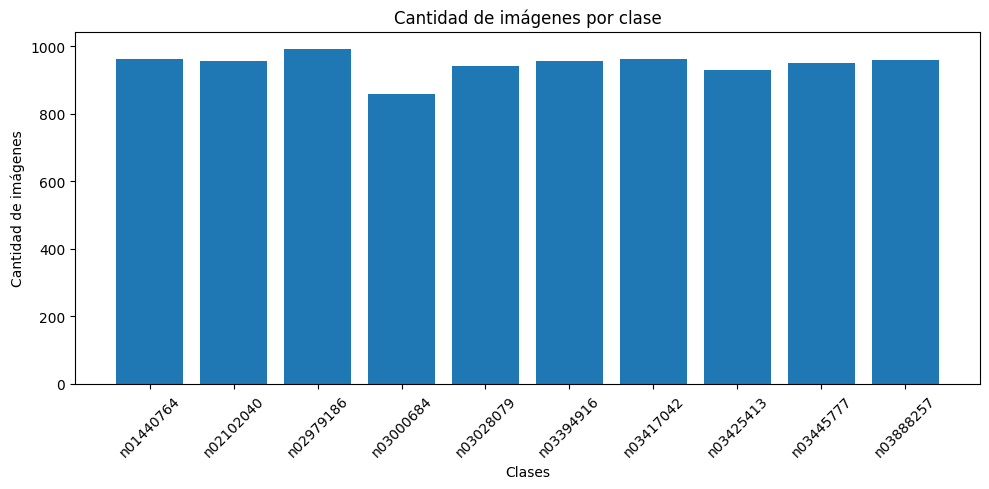

In [23]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

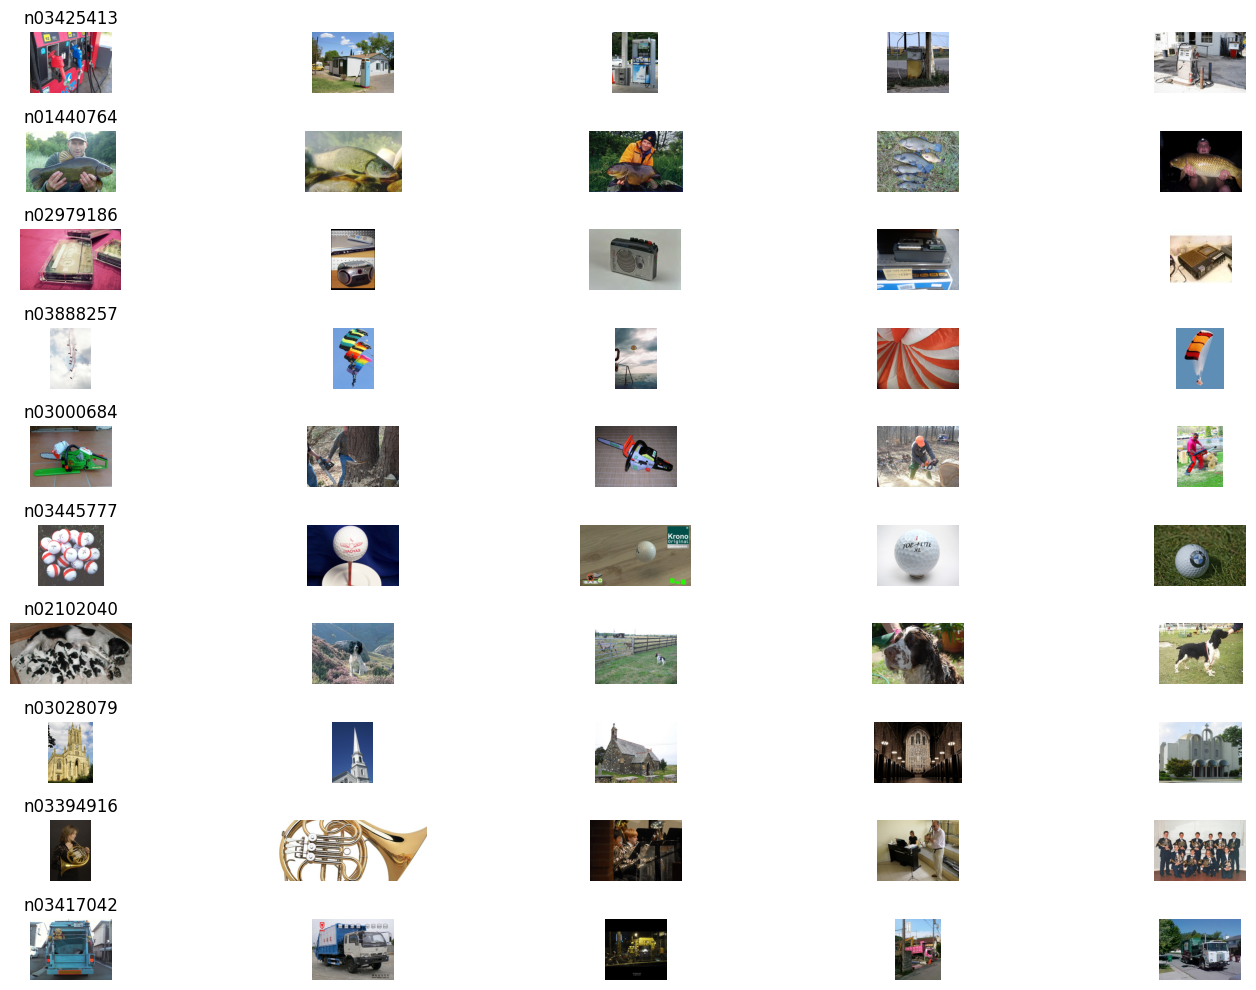

In [24]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [25]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 226
Tamaño MÁS común: (500, 375) (aparece 112 veces)
Tamaño MENOS común: (470, 500) (aparece 1 veces)


## Buscar duplicados

In [26]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


## Conclusión de la exploracion de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# LeNet

## Carga de datos con transforms para LeNet

**Transforms:**

Preprocessing -> train y val/test

Data augmentation -> solo train

In [75]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [29]:
IMG_SIZE = 128  # Reducir tamaño de imagen para ahorrar memoria

In [30]:
val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToDtype(torch.float32, scale=True),
    # T.Normalize(mean=(0.5,), std=(0.5,)),
])

In [31]:
train_dataset = train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=val_tfms_lenet
) 

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([0.4625, 0.4580, 0.4295])
Std: tensor([0.2768, 0.2730, 0.2967])


In [32]:
train_tfms_lenet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


## Regularization

Para saber si necesitamos dropout, entrenar una vez y ver si hay overfitting (val_acc=85% agregar ; val_acc=78% no hace falta)

### Data Augmentation
SOLO PARA TRAINING !!!!!!!!!

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [112]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        super(LeNet, self).__init__()
        self.use_dropout = use_dropout
        self.dropout_p = dropout_p

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)  # 140->136
        self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)                                                   # /2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)           # 68->64
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)         # 32->28
        self.pool3 = nn.AvgPool2d(kernel_size=28, stride=28)  # 28x28 -> 1x1 (válido para entradas 140x140)

        self.tanh = nn.Tanh()
        self.linear = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()

    def forward(self, x):
        # x: [B, C=3, 140, 140]
        x = self.tanh(self.conv1(x))   # -> [B, 6, 136, 136]
        x = self.pool(x)               # -> [B, 6, 68, 68]
        x = self.tanh(self.conv2(x))   # -> [B, 16, 64, 64]
        x = self.pool(x)               # -> [B, 16, 32, 32]
        x = self.tanh(self.conv3(x))   # -> [B, 120, 28, 28]
        x = self.pool3(x)              # -> [B, 120, 1, 1]
        x = self.flatten(x)            # -> [B, 120]
        x = self.tanh(self.linear(x))  # -> [B, 84]
        x = self.dropout(x)
        x = self.output(x)             # -> [B, num_classes]
        return x


In [38]:
summary(LeNet(3, NUM_CLASES), input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1, Tanh: 1, AvgPool2d: 1, Conv2d: 1, Tanh: 1, AvgPool2d: 1, Conv2d: 1, Tanh: 1]

## Entrenamiento con optimizaciones de memoria


In [ ]:
## Entrenamiento con optimizaciones de memoria

# Función mejorada de entrenamiento con gradient accumulation
def train_with_memory_optimization(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=print_log,
    log_every=1,
    gradient_accumulation_steps=4,  # Acumular gradientes antes de actualizar
    mixed_precision=False,  # Usar precisión mixta si está disponible
):
    """
    Entrena el modelo con optimizaciones de memoria.
    
    Args:
        gradient_accumulation_steps: Número de pasos para acumular gradientes
        mixed_precision: Si usar precisión mixta (AMP)
    """
    epoch_train_errors = []
    epoch_val_errors = []
    
    if do_early_stopping:
        early_stopping = EarlyStopping(patience=patience)
    
    # Configurar escalador para precisión mixta si está disponible
    scaler = torch.cuda.amp.GradScaler() if mixed_precision and device == "cuda" else None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            
            # Forward pass con precisión mixta si está disponible
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(x)
                    batch_loss = criterion(output, y) / gradient_accumulation_steps
            else:
                output = model(x)
                batch_loss = criterion(output, y) / gradient_accumulation_steps
            
            # Backward pass
            if scaler is not None:
                scaler.scale(batch_loss).backward()
            else:
                batch_loss.backward()
            
            # Actualizar pesos cada gradient_accumulation_steps
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                if scaler is not None:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()
            
            train_loss += batch_loss.item() * gradient_accumulation_steps
            
            # Limpiar memoria periódicamente
            if batch_idx % 10 == 0 and device == "mps":
                torch.mps.empty_cache()
        
        train_loss /= len(train_loader)
        epoch_train_errors.append(train_loss)
        
        # Evaluación
        val_loss = evaluate(model, criterion, val_loader, device)
        epoch_val_errors.append(val_loss)
        
        if do_early_stopping:
            early_stopping(val_loss)
        
        if log_fn is not None and (epoch + 1) % log_every == 0:
            log_fn(epoch, train_loss, val_loss)
        
        if do_early_stopping and early_stopping.early_stop:
            print(f"Detener entrenamiento en la época {epoch}, la mejor pérdida fue {early_stopping.best_score:.5f}")
            break
    
    return epoch_train_errors, epoch_val_errors


In [8]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)
# optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

In [6]:


letnet_model = LeNet(3,10).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

# epoch_train_errors, epoch_val_errors = train(
#     letnet_model,
#     optimizer,
#     criterion,
#     train_loader,
#     val_loader,
#     DEVICE,
#     do_early_stopping=True,
#     patience=10,
#     epochs=EPOCHS,
#     log_fn=print_log,
#     log_every=1,
# )

NameError: name 'LeNet' is not defined

In [ ]:
#plot_taining(epoch_train_errors, epoch_val_errors)

In [ ]:
#model_classification_report(letnet_model, val_loader, DEVICE, NUM_CLASES)

## Weight & Biases

In [102]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_2"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

True

In [ ]:
sweep_config = {
    "name": "tarea_1_lenet_memory_optimized",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data - Batch sizes más pequeños para evitar problemas de memoria
        "batch_size": {"values": [16, 32, 64]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [3, 5]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
        
        # Parámetros de optimización de memoria
        "gradient_accumulation_steps": {"values": [2, 4, 8]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: cdj7qahp
Sweep URL: https://wandb.ai/campiglianatalia-ort/Tarea1_LeNet_2/sweeps/cdj7qahp


In [104]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [ ]:
import time 

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep con optimizaciones de memoria.
    """
    # inicializar un nuevo run
    print("[RUN] init", flush=True)
    wandb.init()

    print(f"[RUN] device = {DEVICE}", flush=True)
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing
    run_gradient_accumulation = config.gradient_accumulation_steps

    # modelo
    if run_dropout_p == 0:
        model = LeNet(3,10).to(DEVICE)
    else:
        model = LeNet(3,10,True,run_dropout_p).to(DEVICE)

    # dataloaders con batch size del sweep
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 10 == 0:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)         

    print("[RUN] starting train with memory optimization...", flush=True)
    
    # Usar función de entrenamiento optimizada para memoria
    train_with_memory_optimization(
        model, optimizer, criterion, train_loader, val_loader, 
        device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
        epochs=EPOCHS, log_fn=log_with_timing, log_every=1,
        gradient_accumulation_steps=run_gradient_accumulation
    )
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    wandb.finish()

In [107]:
print("DEVICE = ", DEVICE)

DEVICE =  mps


In [113]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: r3oxifbw with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.003225974094087255
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 13
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.2885 val_loss=2.2611
[EPOCH 2] train_loss=2.2221 val_loss=2.2027
[EPOCH 3] train_loss=2.1796 val_loss=2.1772
[EPOCH 4] train_loss=2.1553 val_loss=2.1631
[EPOCH 5] train_loss=2.1457 val_loss=2.1521
[EPOCH 6] train_loss=2.1336 val_loss=2.1409
[EPOCH 7] train_loss=2.1223 val_loss=2.1302
[EPOCH 8] train_loss=2.1063 val_loss=2.1223
[EPOCH 9] train_loss=2.0972 val_loss=2.1057
[EPOCH 10] train_loss=2.0840 val_loss=2.0968
[EPOCH 11] train_loss=2.0748 val_loss=2.0905
[EPOCH 12] train_loss=2.0692 val_loss=2.0858
[EPOCH 13] train_loss=2.0605 val_loss=2.0776
[EPOCH 14] train_loss=2.0505 val_loss=2.0700
[EPOCH 15] train_loss=2.0449 val_loss=2.0660
[EPOCH 16] train_loss=2.0374 val_loss=2.0561
[EPOCH 17] train_loss=2.0304 val_loss=2.0463
[EPOCH 18] train_loss=2.0160 val_loss=2.0387
[EPOCH 19] train_loss=2.0065 val_loss=2.0278
[EPOCH 20] train_loss=1.9953 val_loss=2.0173
[EPOCH 21] train_loss=1.9826 val_loss=2.0180
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Detener entrenamiento en la época 48, la mejor pérdida fue 1.84142


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂
epoch,49
train_loss,1.78489
val_loss,1.88176


wandb: Agent Starting Run: tnkrj7zj with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0007662011394270889
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3054 val_loss=2.3041
[EPOCH 2] train_loss=2.2996 val_loss=2.2986
[EPOCH 3] train_loss=2.2923 val_loss=2.2903
[EPOCH 4] train_loss=2.2803 val_loss=2.2764
[EPOCH 5] train_loss=2.2632 val_loss=2.2574
[EPOCH 6] train_loss=2.2404 val_loss=2.2389
[EPOCH 7] train_loss=2.2226 val_loss=2.2243
[EPOCH 8] train_loss=2.2089 val_loss=2.2138
[EPOCH 9] train_loss=2.1989 val_loss=2.2052
[EPOCH 10] train_loss=2.1906 val_loss=2.1972
[EPOCH 11] train_loss=2.1838 val_loss=2.1905
[EPOCH 12] train_loss=2.1754 val_loss=2.1847
[EPOCH 13] train_loss=2.1677 val_loss=2.1796
[EPOCH 14] train_loss=2.1669 val_loss=2.1757
[EPOCH 15] train_loss=2.1629 val_loss=2.1723
[EPOCH 16] train_loss=2.1558 val_loss=2.1692
[EPOCH 17] train_loss=2.1551 val_loss=2.1663
[EPOCH 18] train_loss=2.1526 val_loss=2.1637
[EPOCH 19] train_loss=2.1489 val_loss=2.1614
[EPOCH 20] train_loss=2.1484 val_loss=2.1590
[EPOCH 21] train_loss=2.1489 val_loss=2.1568
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█
train_loss,██▇▇▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,100
train_loss,1.98498
val_loss,2.00554


wandb: Agent Starting Run: klkvkefm with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0018843548589133512
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.2985 val_loss=2.2863
[EPOCH 2] train_loss=2.2662 val_loss=2.2440
[EPOCH 3] train_loss=2.2224 val_loss=2.2108
[EPOCH 4] train_loss=2.1981 val_loss=2.1933
[EPOCH 5] train_loss=2.1797 val_loss=2.1805
[EPOCH 6] train_loss=2.1674 val_loss=2.1739
[EPOCH 7] train_loss=2.1597 val_loss=2.1665
[EPOCH 8] train_loss=2.1556 val_loss=2.1605
[EPOCH 9] train_loss=2.1498 val_loss=2.1551
[EPOCH 10] train_loss=2.1443 val_loss=2.1500
[EPOCH 11] train_loss=2.1354 val_loss=2.1449
[EPOCH 12] train_loss=2.1325 val_loss=2.1433
[EPOCH 13] train_loss=2.1288 val_loss=2.1346
[EPOCH 14] train_loss=2.1232 val_loss=2.1305
[EPOCH 15] train_loss=2.1135 val_loss=2.1215
[EPOCH 16] train_loss=2.1044 val_loss=2.1160
[EPOCH 17] train_loss=2.0944 val_loss=2.1055
[EPOCH 18] train_loss=2.0895 val_loss=2.0980
[EPOCH 19] train_loss=2.0821 val_loss=2.0935
[EPOCH 20] train_loss=2.0752 val_loss=2.0892
[EPOCH 21] train_loss=2.0753 val_loss=2.0862
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,██▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,███▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▁▁▂▁▁
epoch,100
train_loss,1.73892
val_loss,1.77425


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: io1wlzic with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.001195183860282529
wandb: 	optimizer: sgd
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3013 val_loss=2.2971
[EPOCH 2] train_loss=2.2923 val_loss=2.2852
[EPOCH 3] train_loss=2.2735 val_loss=2.2621
[EPOCH 4] train_loss=2.2482 val_loss=2.2354
[EPOCH 5] train_loss=2.2227 val_loss=2.2180
[EPOCH 6] train_loss=2.2060 val_loss=2.2071
[EPOCH 7] train_loss=2.1975 val_loss=2.1972
[EPOCH 8] train_loss=2.1847 val_loss=2.1892
[EPOCH 9] train_loss=2.1770 val_loss=2.1833
[EPOCH 10] train_loss=2.1733 val_loss=2.1788
[EPOCH 11] train_loss=2.1627 val_loss=2.1745
[EPOCH 12] train_loss=2.1659 val_loss=2.1710
[EPOCH 13] train_loss=2.1571 val_loss=2.1670
[EPOCH 14] train_loss=2.1583 val_loss=2.1636
[EPOCH 15] train_loss=2.1529 val_loss=2.1606
[EPOCH 16] train_loss=2.1535 val_loss=2.1573
[EPOCH 17] train_loss=2.1444 val_loss=2.1538
[EPOCH 18] train_loss=2.1422 val_loss=2.1508
[EPOCH 19] train_loss=2.1389 val_loss=2.1481
[EPOCH 20] train_loss=2.1368 val_loss=2.1454
[EPOCH 21] train_loss=2.1338 val_loss=2.1434
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,██▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_loss,██▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,100
train_loss,1.90078
val_loss,1.92964


wandb: Agent Starting Run: uias46u2 with config:
wandb: 	batch_size: 256
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.002520572419187585
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3007 val_loss=2.2867
[EPOCH 2] train_loss=2.2588 val_loss=2.2260
[EPOCH 3] train_loss=2.1989 val_loss=2.1912
[EPOCH 4] train_loss=2.1732 val_loss=2.1744
[EPOCH 5] train_loss=2.1590 val_loss=2.1635
[EPOCH 6] train_loss=2.1498 val_loss=2.1551
[EPOCH 7] train_loss=2.1416 val_loss=2.1466
[EPOCH 8] train_loss=2.1323 val_loss=2.1395
[EPOCH 9] train_loss=2.1302 val_loss=2.1343
[EPOCH 10] train_loss=2.1225 val_loss=2.1279
[EPOCH 11] train_loss=2.1124 val_loss=2.1232
[EPOCH 12] train_loss=2.1085 val_loss=2.1173
[EPOCH 13] train_loss=2.1025 val_loss=2.1120
[EPOCH 14] train_loss=2.0969 val_loss=2.1042
[EPOCH 15] train_loss=2.0833 val_loss=2.0922
[EPOCH 16] train_loss=2.0700 val_loss=2.0775
[EPOCH 17] train_loss=2.0576 val_loss=2.0653
[EPOCH 18] train_loss=2.0487 val_loss=2.0579
[EPOCH 19] train_loss=2.0398 val_loss=2.0470
[EPOCH 20] train_loss=2.0310 val_loss=2.0538
[EPOCH 21] train_loss=2.0226 val_loss=2.0363
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁
epoch,100
train_loss,1.59091
val_loss,1.61063


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hdnjfko9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00010445820875520352
wandb: 	optimizer: sgd
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3060 val_loss=2.3040
[EPOCH 2] train_loss=2.3046 val_loss=2.3030
[EPOCH 3] train_loss=2.3038 val_loss=2.3019
[EPOCH 4] train_loss=2.3025 val_loss=2.3009
[EPOCH 5] train_loss=2.3012 val_loss=2.2999
[EPOCH 6] train_loss=2.3003 val_loss=2.2989
[EPOCH 7] train_loss=2.2994 val_loss=2.2978
[EPOCH 8] train_loss=2.2983 val_loss=2.2967
[EPOCH 9] train_loss=2.2973 val_loss=2.2955
[EPOCH 10] train_loss=2.2961 val_loss=2.2943
[EPOCH 11] train_loss=2.2948 val_loss=2.2931
[EPOCH 12] train_loss=2.2935 val_loss=2.2918
[EPOCH 13] train_loss=2.2920 val_loss=2.2904
[EPOCH 14] train_loss=2.2906 val_loss=2.2889
[EPOCH 15] train_loss=2.2889 val_loss=2.2873
[EPOCH 16] train_loss=2.2875 val_loss=2.2856
[EPOCH 17] train_loss=2.2855 val_loss=2.2839
[EPOCH 18] train_loss=2.2839 val_loss=2.2820
[EPOCH 19] train_loss=2.2818 val_loss=2.2800
[EPOCH 20] train_loss=2.2801 val_loss=2.2779
[EPOCH 21] train_loss=2.2774 val_loss=2.2757
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss,████████▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,███████▇▇▇▆▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,2.15147
val_loss,2.16504


wandb: Agent Starting Run: ztdqvq6k with config:
wandb: 	batch_size: 256
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0003799383764039915
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 13
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3050 val_loss=2.3045
[EPOCH 2] train_loss=2.3029 val_loss=2.3027
[EPOCH 3] train_loss=2.3016 val_loss=2.3010
[EPOCH 4] train_loss=2.2993 val_loss=2.2990
[EPOCH 5] train_loss=2.2971 val_loss=2.2967
[EPOCH 6] train_loss=2.2948 val_loss=2.2937
[EPOCH 7] train_loss=2.2910 val_loss=2.2898
[EPOCH 8] train_loss=2.2863 val_loss=2.2845
[EPOCH 9] train_loss=2.2802 val_loss=2.2775
[EPOCH 10] train_loss=2.2717 val_loss=2.2685
[EPOCH 11] train_loss=2.2613 val_loss=2.2578
[EPOCH 12] train_loss=2.2494 val_loss=2.2460
[EPOCH 13] train_loss=2.2355 val_loss=2.2338
[EPOCH 14] train_loss=2.2228 val_loss=2.2224
[EPOCH 15] train_loss=2.2112 val_loss=2.2125
[EPOCH 16] train_loss=2.2014 val_loss=2.2039
[EPOCH 17] train_loss=2.1919 val_loss=2.1966
[EPOCH 18] train_loss=2.1847 val_loss=2.1901
[EPOCH 19] train_loss=2.1793 val_loss=2.1844
[EPOCH 20] train_loss=2.1725 val_loss=2.1794
[EPOCH 21] train_loss=2.1672 val_loss=2.1749
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▇▇▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█████▇▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,100
train_loss,2.04402
val_loss,2.05795


wandb: Agent Starting Run: 3ctuuv8w with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00015270643176977782
wandb: 	optimizer: sgd
wandb: 	patience: 5
wandb: 	seed: 13
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3056 val_loss=2.3063
[EPOCH 2] train_loss=2.3047 val_loss=2.3050
[EPOCH 3] train_loss=2.3041 val_loss=2.3037
[EPOCH 4] train_loss=2.3028 val_loss=2.3024
[EPOCH 5] train_loss=2.3008 val_loss=2.3011
[EPOCH 6] train_loss=2.2996 val_loss=2.2998
[EPOCH 7] train_loss=2.2985 val_loss=2.2984
[EPOCH 8] train_loss=2.2967 val_loss=2.2970
[EPOCH 9] train_loss=2.2961 val_loss=2.2955
[EPOCH 10] train_loss=2.2939 val_loss=2.2938
[EPOCH 11] train_loss=2.2924 val_loss=2.2921
[EPOCH 12] train_loss=2.2903 val_loss=2.2902
[EPOCH 13] train_loss=2.2887 val_loss=2.2883
[EPOCH 14] train_loss=2.2867 val_loss=2.2861
[EPOCH 15] train_loss=2.2847 val_loss=2.2839
[EPOCH 16] train_loss=2.2817 val_loss=2.2815
[EPOCH 17] train_loss=2.2793 val_loss=2.2789
[EPOCH 18] train_loss=2.2773 val_loss=2.2762
[EPOCH 19] train_loss=2.2739 val_loss=2.2735
[EPOCH 20] train_loss=2.2716 val_loss=2.2705
[EPOCH 21] train_loss=2.2680 val_loss=2.2676
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,████▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,███▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,100
train_loss,2.15302
val_loss,2.16228


wandb: Agent Starting Run: m0vslnno with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0007745676497859552
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 13
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.3008 val_loss=2.2953
[EPOCH 2] train_loss=2.2887 val_loss=2.2829
[EPOCH 3] train_loss=2.2723 val_loss=2.2653
[EPOCH 4] train_loss=2.2493 val_loss=2.2428
[EPOCH 5] train_loss=2.2259 val_loss=2.2209
[EPOCH 6] train_loss=2.2018 val_loss=2.2039
[EPOCH 7] train_loss=2.1861 val_loss=2.1918
[EPOCH 8] train_loss=2.1737 val_loss=2.1822
[EPOCH 9] train_loss=2.1646 val_loss=2.1747
[EPOCH 10] train_loss=2.1586 val_loss=2.1692
[EPOCH 11] train_loss=2.1511 val_loss=2.1651
[EPOCH 12] train_loss=2.1447 val_loss=2.1615
[EPOCH 13] train_loss=2.1440 val_loss=2.1583
[EPOCH 14] train_loss=2.1398 val_loss=2.1551
[EPOCH 15] train_loss=2.1354 val_loss=2.1521
[EPOCH 16] train_loss=2.1345 val_loss=2.1491
[EPOCH 17] train_loss=2.1300 val_loss=2.1462
[EPOCH 18] train_loss=2.1256 val_loss=2.1437
[EPOCH 19] train_loss=2.1241 val_loss=2.1410
[EPOCH 20] train_loss=2.1239 val_loss=2.1388
[EPOCH 21] train_loss=2.1216 val_loss=2.1357
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch,100
train_loss,1.93288
val_loss,1.95702


wandb: Agent Starting Run: dbxl97ko with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0016244854422284864
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = mps
[RUN] starting train...
[EPOCH 1] train_loss=2.2921 val_loss=2.2777
[EPOCH 2] train_loss=2.2560 val_loss=2.2406
[EPOCH 3] train_loss=2.2166 val_loss=2.2103
[EPOCH 4] train_loss=2.1909 val_loss=2.1911
[EPOCH 5] train_loss=2.1724 val_loss=2.1766
[EPOCH 6] train_loss=2.1601 val_loss=2.1690
[EPOCH 7] train_loss=2.1510 val_loss=2.1622
[EPOCH 8] train_loss=2.1440 val_loss=2.1568
[EPOCH 9] train_loss=2.1387 val_loss=2.1515
[EPOCH 10] train_loss=2.1295 val_loss=2.1460
[EPOCH 11] train_loss=2.1294 val_loss=2.1407
[EPOCH 12] train_loss=2.1239 val_loss=2.1357
[EPOCH 13] train_loss=2.1212 val_loss=2.1314
[EPOCH 14] train_loss=2.1146 val_loss=2.1276
[EPOCH 15] train_loss=2.1136 val_loss=2.1240
[EPOCH 16] train_loss=2.1060 val_loss=2.1201
[EPOCH 17] train_loss=2.1041 val_loss=2.1151
[EPOCH 18] train_loss=2.0934 val_loss=2.1098
[EPOCH 19] train_loss=2.0896 val_loss=2.1017
[EPOCH 20] train_loss=2.0809 val_loss=2.0940
[EPOCH 21] train_loss=2.0697 val_loss=2.0830
[EPOCH 22] train_loss

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,██▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,100
train_loss,1.73628
val_loss,1.79451


## Evaluación final tomando mejor modelo

In [ ]:
api = wandb.Api()

# ULTIMA CORRIDA
# Create sweep with ID: 2ff0um8y
# Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_2/sweeps/2ff0um8y

ENTITY = "campiglianatalia-ort"
PROJECT = "Tarea1_LeNet_2"

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")

# nos traemos el sweep (objeto) para analizar los resultados
# sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
 
# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print("best run:", best_run)
# print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")
# print("Best run metrics:", best_run.summary)

print("Best run name:", best_run.name)
print("Best run name:", best_run.id)
print("Best run config:", best_run.config)

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


best run: <Run campiglianatalia-ort/Tarea1_LeNet_2/3ctuuv8w (finished)>
Best run name: leafy-sweep-11
Best run name: 3ctuuv8w
Best run config: {"seed": {"value": 13}, "_wandb": {"value": {"e": {"0ycmkon0px2mzrwtnkjq4827zfsoo28g": {"os": "macOS-15.1-arm64-arm-64bit-Mach-O", "git": {"commit": "5e42fa305319da090cce93c591d97cb4d00adebd", "remote": "https://github.com/nataliacampiglia/tdl_tarea_1.git"}, "disk": {"/": {"used": "210605301760", "total": "494384795648"}}, "host": "192.168.1.55", "root": "/Users/nataliacampigliastemphelet/master/tdl_tarea_1", "apple": {"name": "Apple M4 Pro", "gpuCores": 16, "memoryGb": 24, "ecpuCores": 4, "pcpuCores": 8, "ramTotalBytes": "25769803776", "swapTotalBytes": "3221225472"}, "email": "campiglianatalia@gmail.com", "memory": {"total": "25769803776"}, "python": "CPython 3.13.7", "program": "./Tarea_1_letra.ipynb", "codePath": "Tarea_1_letra.ipynb", "writerId": "0ycmkon0px2mzrwtnkjq4827zfsoo28g", "cpu_count": 12, "startedAt": "2025-10-11T11:16:27.902578Z"

<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [151]:
attrs = [a for a in dir(best_run) if not a.startswith("_")]
print(attrs)

['client', 'config', 'create', 'delete', 'dir', 'display', 'entity', 'file', 'files', 'history', 'id', 'json_config', 'lastHistoryStep', 'load', 'load_full_data', 'log_artifact', 'logged_artifacts', 'metadata', 'name', 'path', 'project', 'rawconfig', 'save', 'scan_history', 'server_provides_internal_id_field', 'snake_to_camel', 'state', 'storage_id', 'summary', 'summary_metrics', 'sweep', 'sweep_name', 'system_metrics', 'to_html', 'update', 'upload_file', 'url', 'use_artifact', 'used_artifacts', 'user', 'username', 'wait_until_finished']


In [152]:
print("SUMMARY:",best_run.summary_metrics)


SUMMARY: {"_runtime":3689,"_step":99,"_timestamp":1760188840.7544808,"_wandb":{"runtime":3689},"epoch":100,"train_loss":2.153021275997162,"val_loss":2.1622761249542237}


In [149]:
import json

s = best_run.summary_metrics  # o best_run.summary
if isinstance(s, dict):
    val_loss = s.get("val_loss")
elif isinstance(s, str):
    val_loss = json.loads(s).get("val_loss")
else:
    # fallback por si W&B lo envuelve en un objeto raro
    val_loss = getattr(s, "get", lambda *_: None)("val_loss")

print("val_loss:", val_loss)

val_loss: 2.1622761249542237


In [ ]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

In [164]:

config = best_run.config
print(config)

label_smoothing = json.loads(config).get("label_smoothing")
label_smoothing = label_smoothing.get("value")

# label_smoothing = json.loads(label_smoothing).get("value")
print(label_smoothing)
# criterion
if label_smoothing == 0:
    criterion = nn.CrossEntropyLoss().to(DEVICE)
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(DEVICE)


# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
   
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

{"seed": {"value": 13}, "_wandb": {"value": {"e": {"0ycmkon0px2mzrwtnkjq4827zfsoo28g": {"os": "macOS-15.1-arm64-arm-64bit-Mach-O", "git": {"commit": "5e42fa305319da090cce93c591d97cb4d00adebd", "remote": "https://github.com/nataliacampiglia/tdl_tarea_1.git"}, "disk": {"/": {"used": "210605301760", "total": "494384795648"}}, "host": "192.168.1.55", "root": "/Users/nataliacampigliastemphelet/master/tdl_tarea_1", "apple": {"name": "Apple M4 Pro", "gpuCores": 16, "memoryGb": 24, "ecpuCores": 4, "pcpuCores": 8, "ramTotalBytes": "25769803776", "swapTotalBytes": "3221225472"}, "email": "campiglianatalia@gmail.com", "memory": {"total": "25769803776"}, "python": "CPython 3.13.7", "program": "./Tarea_1_letra.ipynb", "codePath": "Tarea_1_letra.ipynb", "writerId": "0ycmkon0px2mzrwtnkjq4827zfsoo28g", "cpu_count": 12, "startedAt": "2025-10-11T11:16:27.902578Z", "executable": "/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/bin/python", "codePathLocal": "Tarea_1_letra.ipynb", "cpu_count_lo

In [166]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

NameError: name 'model_classification_report' is not defined

In [173]:
import wandb, json

api = wandb.Api()

ENTITY  = "campiglianatalia-ort"   # usá el entity correcto según tu URL
PROJECT = "Tarea1_LeNet_2"
RUN_ID  = "uias46u2"               # <- el run que querés

# 1) Traer el run por path
run_path = f"{ENTITY}/{PROJECT}/{RUN_ID}"
run = api.run(run_path)

print("RUN:", run.id, "| name:", run.name)
print("URL:", run.url)
print("STATE:", run.state)
print("CONFIG:", dict(run.config))

# 2) Leer summary de forma segura (algunas versiones lo devuelven como string)
def summary_dict(r):
    s = getattr(r, "summary_metrics", None)
    if isinstance(s, str):
        try:
            return json.loads(s)
        except Exception:
            return {}
    if isinstance(s, dict):
        return s
    # fallback para r.summary con wrapper antiguo
    s2 = getattr(getattr(r, "summary", {}), "_json_dict", {})
    if isinstance(s2, dict):
        return s2
    return {}

summary = summary_dict(run)
print("SUMMARY KEYS:", [k for k in summary.keys() if not k.startswith("_")])
print("val_loss:", summary.get("val_loss"))

# 3) Descargar el modelo de ese run
#    Si el archivo exacto no existe, listá los .pth disponibles.
try:
    run.file("model.pth").download(replace=True)
    print("Descargado: model.pth")
except Exception as e:
    print("No encontré model.pth directamente:", e)
    print("Buscando .pth disponibles en el run...")
    pth_files = [f for f in run.files() if f.name.endswith(".pth")]
    for f in pth_files:
        print("->", f.name, f.size)
    if pth_files:
        pth_files[0].download(replace=True)
        print("Descargado:", pth_files[0].name)
    else:
        print("No hay archivos .pth en este run.")


RUN: uias46u2 | name: feasible-sweep-8
URL: https://wandb.ai/campiglianatalia-ort/Tarea1_LeNet_2/runs/uias46u2
STATE: finished
CONFIG: {'seed': 7, 'patience': 3, 'dropout_p': 0.3, 'optimizer': 'sgd', 'batch_size': 256, 'early_stop': True, 'weight_decay': 0.0005, 'learning_rate': 0.002520572419187585, 'label_smoothing': 0}
SUMMARY KEYS: ['epoch', 'train_loss', 'val_loss']
val_loss: 1.6106284777323403
Descargado: model.pth


In [174]:
letnet_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [178]:
def getValue(data, value_name):
    if isinstance(data, dict):
        value = data.get(value_name)
    elif isinstance(data, str):
        value = json.loads(data).get(value_name)
    else:
        # fallback por si W&B lo envuelve en un objeto raro
        value = getattr(data, "get", lambda *_: None)(value_name)

    print("val_loss:", val_loss)
    return value

In [181]:

config = run.config
print(config)

label_smoothing = getValue(config, "label_smoothing")

# label_smoothing = json.loads(label_smoothing).get("value")
print(label_smoothing)
# criterion
if label_smoothing == 0:
    criterion = nn.CrossEntropyLoss().to(DEVICE)
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(DEVICE)


# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
   
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

{'seed': 7, 'patience': 3, 'dropout_p': 0.3, 'optimizer': 'sgd', 'batch_size': 256, 'early_stop': True, 'weight_decay': 0.0005, 'learning_rate': 0.002520572419187585, 'label_smoothing': 0}
val_loss: 2.1622761249542237
0
Test Loss: 1.59459


## Conclusión de los datos

In [ ]:
#

# Arquitectura DenseNet


In [19]:
IMG_SIZE = 128

In [40]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

`growth_rate` indica cuántos canales se agregarán en cada capa convolucional dentro de un bloque denso

In [21]:
from torchinfo import summary

in_channels  = 6  # número de canales de entrada
out_channels = 4 # número de canales de salida
dense_layer = DenseLayer(in_channels=in_channels, out_channels=out_channels)
summary(dense_layer, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DenseLayer                               [32, 10, 128, 128]        --
├─BatchNorm2d: 1-1                       [32, 6, 128, 128]         12
├─ReLU: 1-2                              [32, 6, 128, 128]         --
├─Conv2d: 1-3                            [32, 4, 128, 128]         220
Total params: 232
Trainable params: 232
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.34
Input size (MB): 12.58
Forward/backward pass size (MB): 41.94
Params size (MB): 0.00
Estimated Total Size (MB): 54.53

In [41]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [23]:
in_channels = 6  # número de canales de entrada
num_layer   = 5  # número de capas en el bloque denso
growth_rate = 4  # tasa de crecimiento

dense_block = DenseBlock(num_layer, in_channels, growth_rate)

summary(dense_block, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DenseBlock                               [32, 26, 128, 128]        --
├─Sequential: 1-1                        [32, 26, 128, 128]        --
│    └─DenseLayer: 2-1                   [32, 10, 128, 128]        --
│    │    └─BatchNorm2d: 3-1             [32, 6, 128, 128]         12
│    │    └─ReLU: 3-2                    [32, 6, 128, 128]         --
│    │    └─Conv2d: 3-3                  [32, 4, 128, 128]         220
│    └─DenseLayer: 2-2                   [32, 14, 128, 128]        --
│    │    └─BatchNorm2d: 3-4             [32, 10, 128, 128]        20
│    │    └─ReLU: 3-5                    [32, 10, 128, 128]        --
│    │    └─Conv2d: 3-6                  [32, 4, 128, 128]         364
│    └─DenseLayer: 2-3                   [32, 18, 128, 128]        --
│    │    └─BatchNorm2d: 3-7             [32, 14, 128, 128]        28
│    │    └─ReLU: 3-8                    [32, 14, 128, 128]        --
│    │    └─C

In [42]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [25]:
in_channels = 100  # número de canales de entrada
out_channels = 25  # número de canales de salida (en general, se reduce a la mitad)
img_w = 32  # ancho de la imagen
img_h = 32  # alto de la imagen

transition_layer = TransitionLayer(in_channels, out_channels)

summary(transition_layer, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
TransitionLayer                          [32, 25, 64, 64]          --
├─BatchNorm2d: 1-1                       [32, 100, 128, 128]       200
├─ReLU: 1-2                              [32, 100, 128, 128]       --
├─Conv2d: 1-3                            [32, 25, 128, 128]        2,525
├─AvgPool2d: 1-4                         [32, 25, 64, 64]          --
Total params: 2,725
Trainable params: 2,725
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.32
Input size (MB): 209.72
Forward/backward pass size (MB): 524.29
Params size (MB): 0.01
Estimated Total Size (MB): 734.01

In [43]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 224, 224]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 224, 224]        128
├─ReLU: 1-3                                   [32, 64, 224, 224]        --
├─Sequential: 1-4                             [32, 1024, 28, 28]        --
│    └─DenseBlock: 2-1                        [32, 256, 224, 224]       --
│    │    └─Sequential: 3-1                   [32, 256, 224, 224]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 112, 112]       --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 224, 224]       512
│    │    └─ReLU: 3-3                         [32, 256, 224, 224]       --
│    │    └─Conv2d: 3-4                       [32, 128, 224, 224]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 112, 112]       --
│    └

In [54]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)


In [55]:
import torch, gc

def mps_cleanup():
    gc.collect()
    if torch.backends.mps.is_available():
        print('clean')
        torch.mps.empty_cache()
        torch.mps.synchronize()

# Llama esto entre épocas o antes de relanzar un experimento
mps_cleanup()

In [56]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.95"
import torch

In [58]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 1.96413 | Val Loss: 1.97523
Epoch: 002 | Train Loss: 1.73785 | Val Loss: 1.73173
Epoch: 003 | Train Loss: 1.58700 | Val Loss: 1.71261
Epoch: 004 | Train Loss: 1.43542 | Val Loss: 1.62953
Epoch: 005 | Train Loss: 1.33163 | Val Loss: 1.29056
Epoch: 006 | Train Loss: 1.25339 | Val Loss: 1.31544
Epoch: 007 | Train Loss: 1.16752 | Val Loss: 1.43465
Epoch: 008 | Train Loss: 1.12179 | Val Loss: 1.06212
Epoch: 009 | Train Loss: 1.03379 | Val Loss: 1.19727
Epoch: 010 | Train Loss: 0.99982 | Val Loss: 0.90368
Epoch: 011 | Train Loss: 0.93971 | Val Loss: 1.18401
Epoch: 012 | Train Loss: 0.88330 | Val Loss: 0.93990
Epoch: 013 | Train Loss: 0.85531 | Val Loss: 0.89237
Epoch: 014 | Train Loss: 0.81526 | Val Loss: 0.87879
Epoch: 015 | Train Loss: 0.78889 | Val Loss: 0.78679
Epoch: 016 | Train Loss: 0.75328 | Val Loss: 0.98762
Epoch: 017 | Train Loss: 0.73531 | Val Loss: 0.95637
Epoch: 018 | Train Loss: 0.69048 | Val Loss: 1.01287
Epoch: 019 | Train Loss: 0.68922 | Val Loss: 0

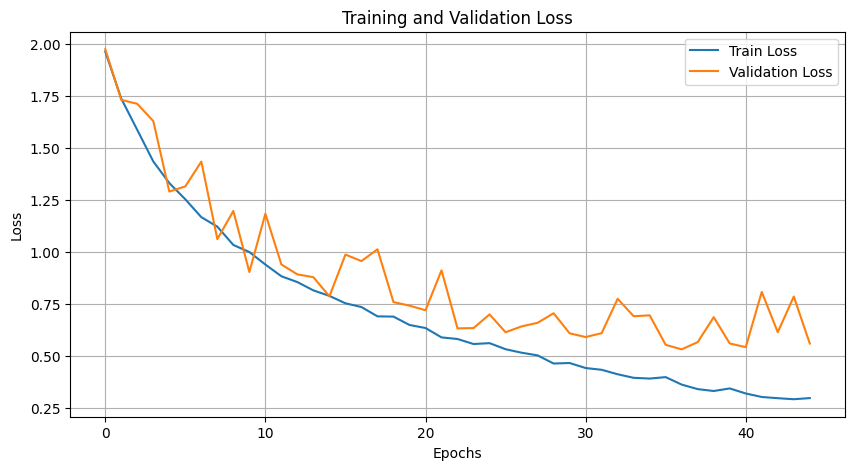

In [61]:
plot_training(train_errors_dn, val_errors_dn)

In [62]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8375

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       387
           1       0.97      0.82      0.89       395
           2       0.77      0.90      0.83       357
           3       0.63      0.75      0.68       386
           4       0.91      0.85      0.88       409
           5       0.82      0.86      0.84       394
           6       0.84      0.90      0.87       389
           7       0.83      0.75      0.79       419
           8       0.85      0.86      0.86       399
           9       0.94      0.80      0.87       390

    accuracy                           0.84      3925
   macro avg       0.85      0.84      0.84      3925
weighted avg       0.85      0.84      0.84      3925



# DenseNet 2

In [105]:
IMG_SIZE = 128 #128
BATCH_SIZE = 16 #64
LR = 0.001
EPOCHS = 100

In [106]:
train_tfms_denseNet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_denseNet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

In [107]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_denseNet, val_tfms_denseNet, BATCH_SIZE, NUM_WORKERS)

In [108]:
import torch, gc


gc.collect()                 # Limpia objetos Python no referenciados
torch.cuda.empty_cache()     # Devuelve memoria al driver (visible en nvidia-smi)
torch.cuda.ipc_collect()


In [111]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

import time
start = time.time()

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

end = time.time()

print(f"Tiempo de ejecución: {end - start:.2f} segundos")

Epoch: 001 | Train Loss: 2.04332 | Val Loss: 1.82233
Epoch: 002 | Train Loss: 1.79971 | Val Loss: 1.93745
Epoch: 003 | Train Loss: 1.68469 | Val Loss: 1.57794
Epoch: 004 | Train Loss: 1.53847 | Val Loss: 1.51436
Epoch: 005 | Train Loss: 1.43973 | Val Loss: 1.76585
Epoch: 006 | Train Loss: 1.33935 | Val Loss: 1.26471
Epoch: 007 | Train Loss: 1.25588 | Val Loss: 1.44376
Epoch: 008 | Train Loss: 1.20701 | Val Loss: 1.11733
Epoch: 009 | Train Loss: 1.12350 | Val Loss: 1.17399
Epoch: 010 | Train Loss: 1.08480 | Val Loss: 1.03386
Epoch: 011 | Train Loss: 1.03111 | Val Loss: 0.97662
Epoch: 012 | Train Loss: 0.99526 | Val Loss: 0.97499
Epoch: 013 | Train Loss: 0.93882 | Val Loss: 0.99116
Epoch: 014 | Train Loss: 0.92028 | Val Loss: 0.90474
Epoch: 015 | Train Loss: 0.87249 | Val Loss: 0.85739
Epoch: 016 | Train Loss: 0.82381 | Val Loss: 0.81815
Epoch: 017 | Train Loss: 0.78975 | Val Loss: 0.73397
Epoch: 018 | Train Loss: 0.76111 | Val Loss: 0.75659
Epoch: 019 | Train Loss: 0.72596 | Val Loss: 0

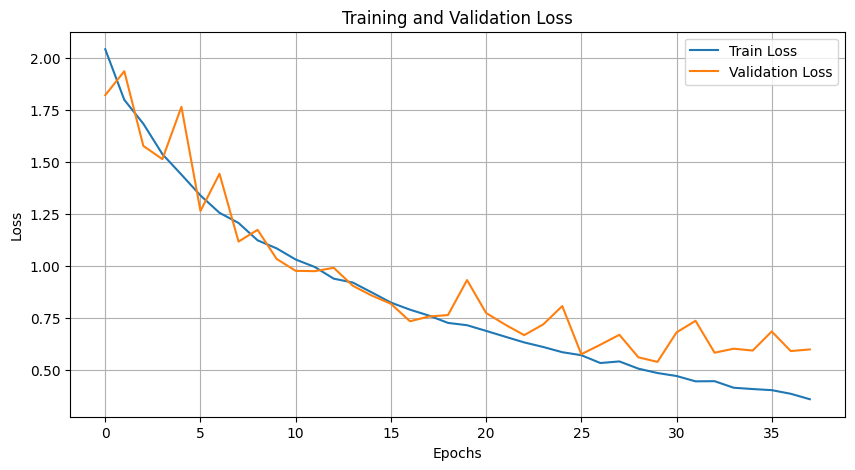

In [113]:
plot_training(train_errors_dn, val_errors_dn)

In [114]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8242

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       387
           1       0.86      0.92      0.89       395
           2       0.80      0.81      0.80       357
           3       0.82      0.46      0.59       386
           4       0.84      0.89      0.87       409
           5       0.65      0.88      0.75       394
           6       0.80      0.95      0.86       389
           7       0.85      0.72      0.78       419
           8       0.89      0.83      0.86       399
           9       0.89      0.85      0.87       390

    accuracy                           0.82      3925
   macro avg       0.83      0.82      0.82      3925
weighted avg       0.83      0.82      0.82      3925



## Carga de datos con transformers

## Data augmentation

## Preprocessing

## Arquitectura del modelo

## Regularización

## Entrenamiento

## Weight & Biases

## Conclusión de los datos

# Comparación ambos modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.